In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from tdnn import TDNN
from learning import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test
train_x, test_x = x_data[:5000], x_data[5000:]
train_y, test_y = y_data[:5000], y_data[5000:]

train_x, val_x = train_x[:4000], train_x[4000:]
train_y, val_y = train_y[:4000], train_y[4000:]

In [4]:
window_size = 30

train_data = SequenceDataset(train_x, train_y, window_size)
train_loader = data.DataLoader(train_data, batch_size=500, shuffle=False)

val_data = SequenceDataset(val_x, val_y, window_size)
val_loader = data.DataLoader(val_data, batch_size=len(val_data), shuffle=False)

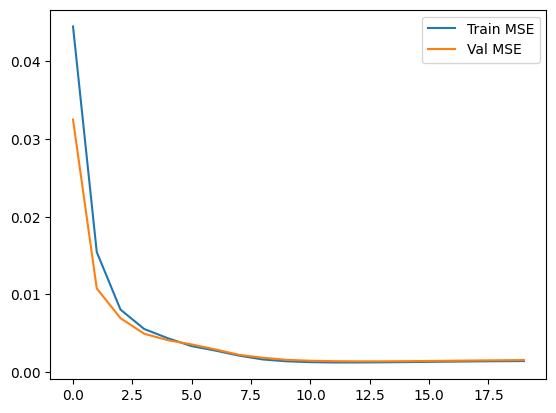

In [6]:
# this code is just a try to see how to plot
'''plt.plot(train_mse_history, label='Train MSE')
plt.plot(val_mse_history, label='Val MSE')
plt.legend()'''

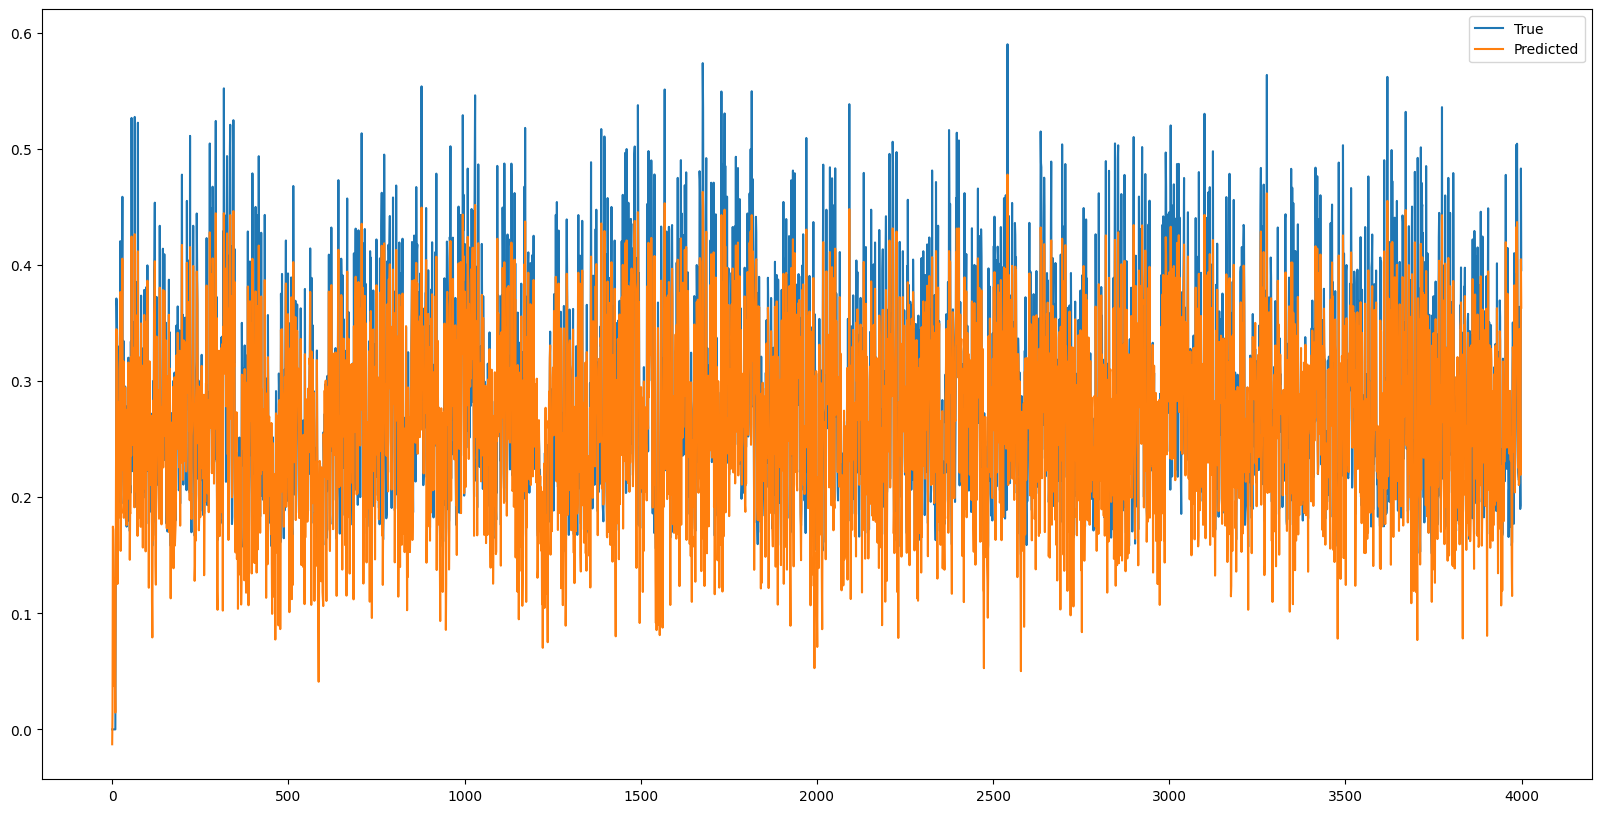

In [7]:
# this code is just a try to see how to plot
'''train_loader = data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)
plt.figure(figsize=(20, 10))
for x, y in train_loader:
    with torch.no_grad():
        out = model(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()'''